In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

**load the data set**

In [2]:
Data = pd.read_csv('plant.csv')
data = Data.copy(deep=True)
data.head()  # prints first 5 elements of dataframe

,Symbol,Synonym Symbol,Scientific Name with Author,National Common Name,Family
0,JUAM,NaN,Justicia americana (L.) Vahl,American water-willow,Acanthaceae
1,JUAM,DIAM2,Dianthera americana L.,NaN,Acanthaceae
2,JUAM,DIAMS,Dianthera americana L. var. subcoriacea (Ferna...,NaN,Acanthaceae
3,JUAM,JUAMS,Justicia americana (L.) Vahl var. subcoriacea ...,NaN,Acanthaceae
4,JUAM,JUMO2,Justicia mortuifluminis Fernald,NaN,Acanthaceae


## 1. Descriptive Analytics:

finding number of rows and columns in the given dataset:

In [3]:
data.shape

(12334, 5)

So we have 12334 records with 5 columns.

finding the **data types** and no of data values missing in each column 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12334 entries, 0 to 12333
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Symbol                       12334 non-null  object
 1   Synonym Symbol               8000 non-null   object
 2   Scientific Name with Author  12334 non-null  object
 3   National Common Name         4330 non-null   object
 4   Family                       12334 non-null  object
dtypes: object(5)
memory usage: 481.9+ KB


we can observe that all our features are **'categorical variables'** and we do have missing values present in **"Synonym Symbol"** and **"National Common Name"** features.

so now let's find the percentage of  missing values present in our data set

MISSINGVALUES
Symbol                            0
Synonym Symbol                 4334
Scientific Name with Author       0
National Common Name           8004
Family                            0
dtype: int64

PERCENTAGE OF MISSING VALUES:
Synonym Symbol          0.351386
National Common Name    0.648938
dtype: float64

NO OF DUPLICATE RECORDS : 0


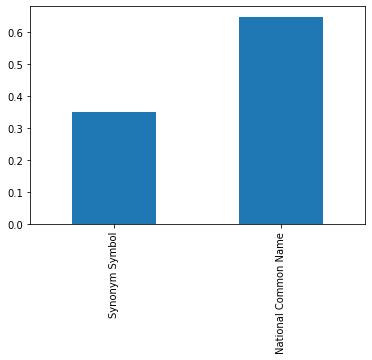

In [5]:
print("MISSINGVALUES")
print(data.isna().sum())
missing_values = data.isnull().sum()
x = missing_values.to_frame()
total_missing_values = x[0].sum()
missing_values = missing_values / len(data)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
print("\nPERCENTAGE OF MISSING VALUES:")
print(missing_values)
missing_values.plot.bar()
print("\nNO OF DUPLICATE RECORDS :",data.duplicated().sum())

Let's find the no of unique families. I’ve chosen only to keep the ‘Symbol’ column as a representation of count because this variable is required for every plant instance(in the bargraph).

In [6]:
print("no of unique classes in family:",data['Family'].nunique())
print("no of unique classes in symbol:",data['Symbol'].nunique())

no of unique classes in family: 170
no of unique classes in symbol: 4334


### plots

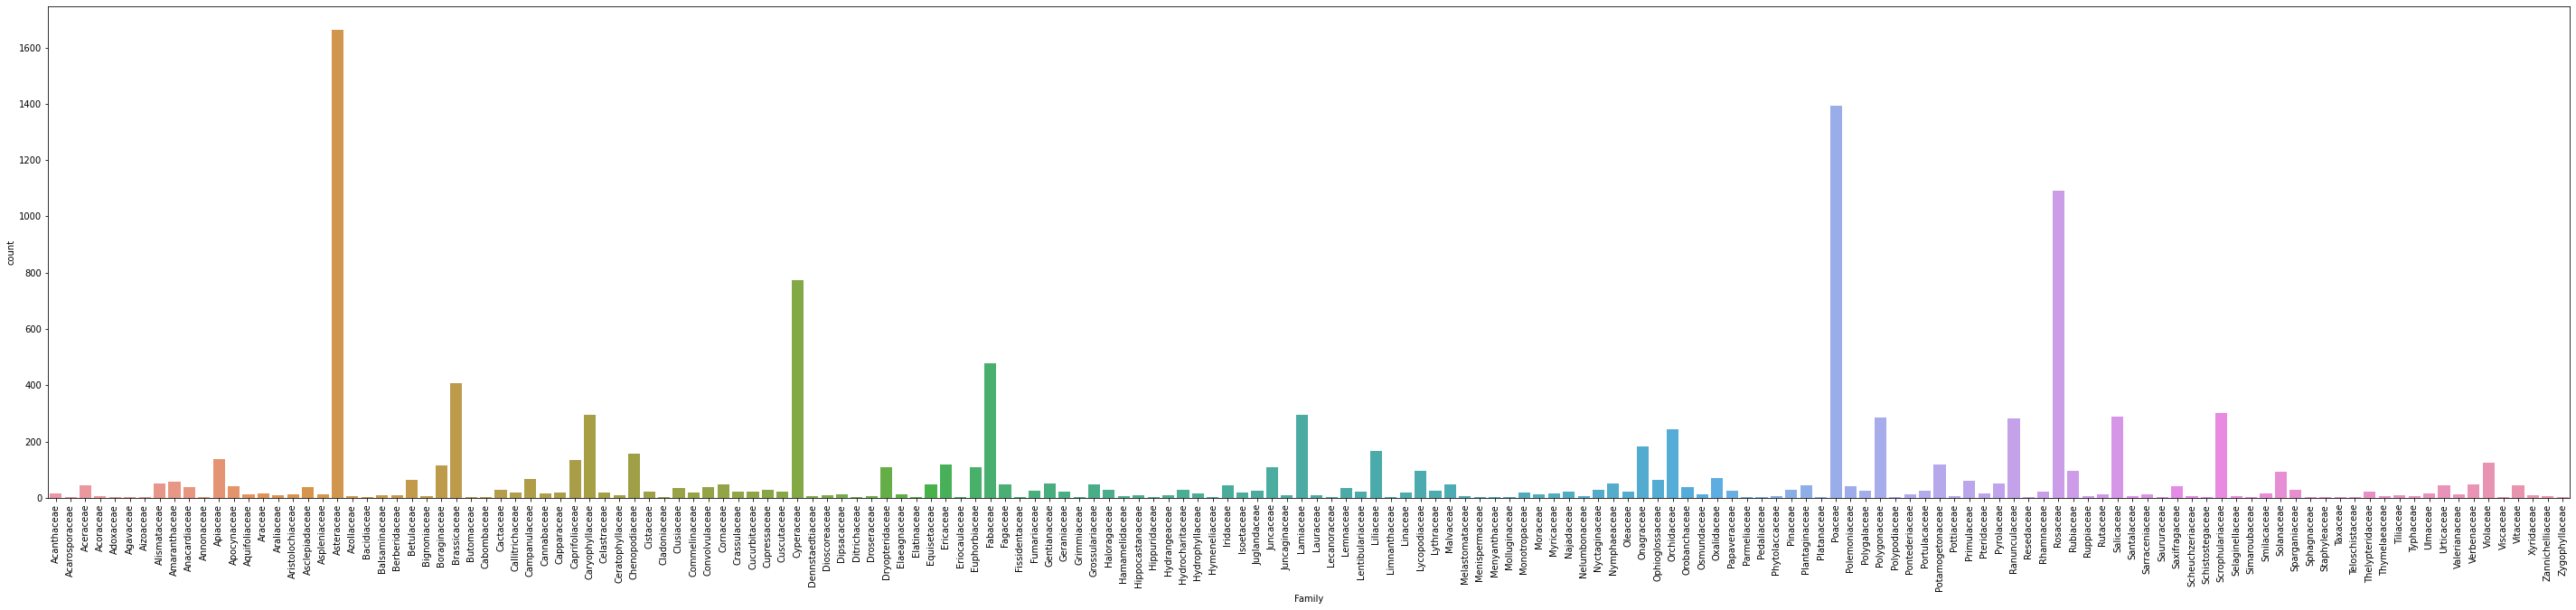

In [7]:
fig_dims = (50,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='Family', data=data, ax=ax)
plt.xticks(rotation = 90)
plt.show()

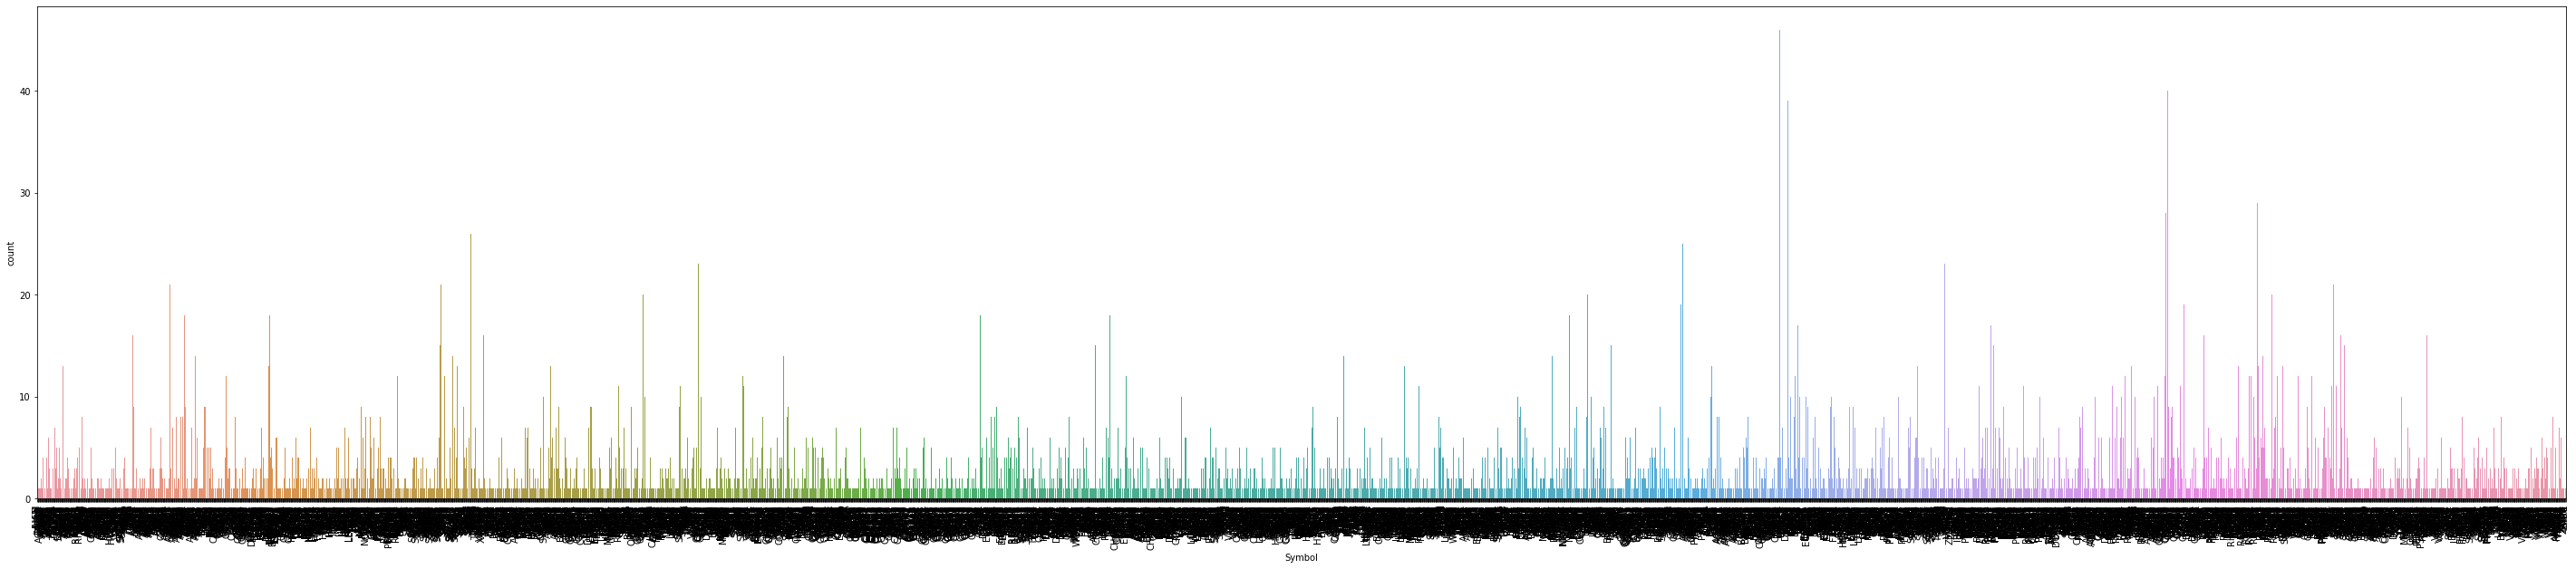

In [8]:
fig_dims = (50,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='Symbol', data=data, ax=ax)
plt.xticks(rotation = 90)
plt.show()

### Data preprocessing:

Let's split the "Scientific Name with Author" into two columns. "Scientific Name" and "Author" will be the new columns after spliting.

In [9]:
splitted = data['Scientific Name with Author'].str.split()
data['Author'] = splitted.str[-1]
data['Scientific Name'] = splitted.str[0] + " " + splitted.str[1]
data.drop('Scientific Name with Author', axis=1, inplace=True)

In [10]:
print("no of unique national common names:",data['National Common Name'].nunique())
print("no of unique  authors:",data['Author'].nunique())
print("no of unique scientific names:",data['Scientific Name'].nunique())
print("no of unique Synonym symbol:",data['Synonym Symbol'].nunique())
target = data['Family']
data.drop('Family', inplace=True, axis=1)
data['Family'] = target
data.head()

no of unique national common names: 3394
no of unique  authors: 1820
no of unique scientific names: 7964
no of unique Synonym symbol: 8000


,Symbol,Synonym Symbol,National Common Name,Author,Scientific Name,Family
0,JUAM,NaN,American water-willow,Vahl,Justicia americana,Acanthaceae
1,JUAM,DIAM2,NaN,L.,Dianthera americana,Acanthaceae
2,JUAM,DIAMS,NaN,Shinners,Dianthera americana,Acanthaceae
3,JUAM,JUAMS,NaN,Fernald,Justicia americana,Acanthaceae
4,JUAM,JUMO2,NaN,Fernald,Justicia mortuifluminis,Acanthaceae


###  Integer encoding


As all our features are categorical data so we need to encode these features to convert our categorical features into numerical features.Because ML algo's accept only no's as input and not strings.

NOTE: we cannot use "label encoder" because it takes NaN,missing values as another category.

In [11]:
x = list(data['Symbol'].unique())

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:index})

data['Symbol'] = data['Symbol'].map(dict_)

In [12]:
x = list(data['Synonym Symbol'].unique())
del x[0] # Delete NaN value from the list of unique classes so that NaN's are not encoded.

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:round(index)})

data['Synonym Symbol'] = data['Synonym Symbol'].map(dict_)

In [13]:
x = list(data['National Common Name'].unique())
del x[1] # Delete NaN value from the list of unique classes so that NaN's are not encoded.

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:round(index)})

data['National Common Name'] = data['National Common Name'].map(dict_)

In [14]:
x = list(data['Family'].unique())

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:index})

data['Family'] = data['Family'].map(dict_)

In [15]:
x = list(data['Author'].unique())

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:index})

data['Author'] = data['Author'].map(dict_)

In [16]:
x = list(data['Scientific Name'].unique())

dict_ = {}
for index, ele in enumerate(x):
  dict_.update({ele:index})

data['Scientific Name'] = data['Scientific Name'].map(dict_)

In [17]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12334 entries, 0 to 12333
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Symbol                12334 non-null  int64  
 1   Synonym Symbol        8000 non-null   float64
 2   National Common Name  4330 non-null   float64
 3   Author                12334 non-null  int64  
 4   Scientific Name       12334 non-null  int64  
 5   Family                12334 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 578.3 KB
None


,Symbol,Synonym Symbol,National Common Name,Author,Scientific Name,Family
0,0,NaN,0.0,0,0,0
1,0,0.0,NaN,1,1,0
2,0,1.0,NaN,2,1,0
3,0,2.0,NaN,3,0,0
4,0,3.0,NaN,3,2,0


we can see that except **NaN** values all values are encoded to numbers.Now we try to find the missing values using k-nearest neighbours technique.

**k-nearest neighbour** uses mean to calculate missing values so all values will become float datatype.so after finding the missing values we need to change them to integers 


In [18]:
NaN_val = KNNImputer(n_neighbors=5)
encoded_data = pd.DataFrame(NaN_val .fit_transform(data))
encoded_data.columns = data.columns
encoded_data.index = data.index

encoded_data.head()

,Symbol,Synonym Symbol,National Common Name,Author,Scientific Name,Family
0,0.0,2.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.2,1.0,1.0,0.0
2,0.0,1.0,2.0,2.0,1.0,0.0
3,0.0,2.0,2.0,3.0,0.0,0.0
4,0.0,3.0,2.0,3.0,2.0,0.0


Now let's change the float values to integers

In [19]:
def float_to_integers(data):

  col = ['Symbol', 'Synonym Symbol', 'National Common Name', 'Author','Scientific Name', 'Family']

  for index,value in enumerate(col):
    list1 = []
    for j in data[value]:
      list1.append(round(j))
    
    x = {value:list1}
    if index == 0:
      df = pd.DataFrame(x)
    else:
      df[value] = pd.DataFrame(x)

  return df

In [21]:
encoded_data = float_to_integers(encoded_data)
encoded_data.head()

,Symbol,Synonym Symbol,National Common Name,Author,Scientific Name,Family
0,0,2,0,0,0,0
1,0,0,2,1,1,0
2,0,1,2,2,1,0
3,0,2,2,3,0,0
4,0,3,2,3,2,0


clearly we know the target/output variable is family.Now let us select the best features that predicts the output.

### Feature Selection:



#### correlation

since our data is **categorial** we cannot use correlation formula.so What we need is something that will look like correlation, but will work with categorical values — or more formally, we’re looking for a measure of association between two categorical features. 

Introducing: **"Cramér’s V"**. It is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:

Similarly to correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t)
Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y
This may not be an accurate description of the data since one feature may depend on another but the reverse need not be true.

so to preserve it we need an "asymmetric measure of association between categorical features". And this is exactly what Theil’s U is.

**Theil’s U**, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between x and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur. Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before


In [22]:
REPLACE = 'replace'
DROP = 'drop'
DROP_SAMPLES = 'drop_samples'
DROP_FEATURES = 'drop_features'
SKIP = 'skip'
DEFAULT_REPLACE_VALUE = 0.0

In [23]:
def conditional_entropy(x,y,nan_strategy=REPLACE,nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy)
    return entropy

In [24]:
def theils_u(x, y, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-
    categorical association. This is the uncertainty of x given y: value is
    on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [25]:
def replace_nan_with_value(x, y, value):
    x = [v if v == v and v is not None else value for v in x]  # NaN != NaN
    y = [v if v == v and v is not None else value for v in y]
    return x, y

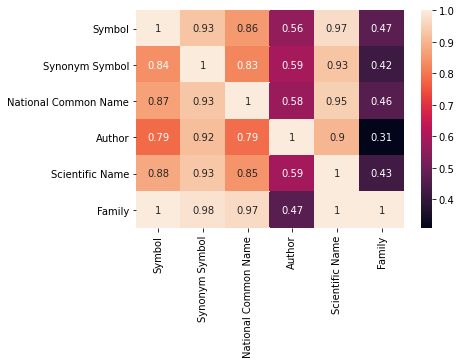

In [26]:
list_2 = []
matrix_2 = []

for i in encoded_data.columns:
  for j in encoded_data.columns:

    a = encoded_data[i]
    b = encoded_data[j]

    result_2 = theils_u(a,b)

    list_2.append(result_2)
  
matrix_2.append(list_2)

theils_u_matrix_2 = np.reshape(matrix_2[0], (6,6))
sns.heatmap(theils_u_matrix_2, xticklabels=encoded_data.columns, yticklabels=encoded_data.columns, annot=True)

Strongly correlated features are more linearly dependent, and hence have similar effect on the target variable. Hence we can retain one while dropping the other. For this we can choose the threshold to be 0.9 .

In [27]:
columns = np.full((theils_u_matrix_2.shape[0],), True, dtype=bool)
for i in range(theils_u_matrix_2.shape[0]):
    for j in range(i+1, theils_u_matrix_2.shape[0]):
        if theils_u_matrix_2[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = encoded_data.columns[columns]

In [28]:
selected_columns

Index(['Symbol', 'National Common Name', 'Author', 'Family'], dtype='object')

As we can see after removing the features having more than 90% correlation score, we are left with four variables.

In [29]:
data_final = encoded_data[selected_columns]

In [30]:
data_final.head()

,Symbol,National Common Name,Author,Family
0,0,0,0,0
1,0,2,1,0
2,0,2,2,0
3,0,2,3,0
4,0,2,3,0


**saving this dataset  for predictive analysis(data mining)**

In [31]:
data_final.to_csv('plants1.csv', index=False, header=False)

we know that family is the target variable.so let us seperate that column from the dataset because we have to predict it

In [32]:
X = data_final.drop('Family', axis=1)
Y = data_final['Family']

### P-value:

The **P value**, or **calculated probability**, is the probability of finding the observed/extreme results when the null hypothesis(H0) of a study given problem is true. If your P-value is less than the chosen significance level then you reject the null hypothesis i.e. accept that your sample claims to support the alternative hypothesis

These measured p-values can be used to decide whether to keep a feature or not.

let us  assume the null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”.
Then we build a small regression model and calculate the p values.
If the p values is higher than the threshold, we discard that combination of features.


Now we will select the columns based on how they affect the p-value.

In [33]:
selected_columns = X.columns.values

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns_pi = backwardElimination(X.values, Y.values, SL, selected_columns)

In [34]:
selected_columns_pi

array(['Symbol', 'National Common Name'], dtype=object)

In [35]:
X = pd.DataFrame(data=data_modeled, columns=selected_columns_pi)
X.head()

,Symbol,National Common Name
0,0,0
1,0,2
2,0,2
3,0,2
4,0,2


In [36]:
x = X.copy(deep=True)
x['Family'] = Y.values
x.head()

,Symbol,National Common Name,Family
0,0,0,0
1,0,2,0
2,0,2,0
3,0,2,0
4,0,2,0


We have checked the statistical significance of our features using correlation and p-value tests.
We have performed Feature selection based on statsical measures and have collected the clean dataset.

with the clean dataset,

### Data Visualization

#### boxplots

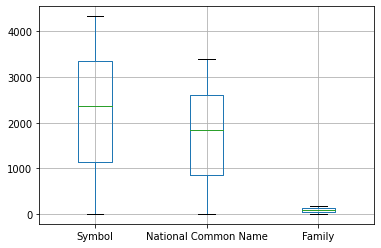

In [37]:
boxplot = x.boxplot(column=['Symbol', 'National Common Name', 'Family'])

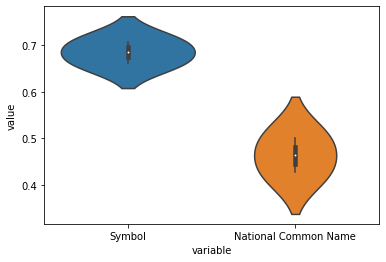

In [38]:
df = pd.DataFrame(data = np.random.random(size=(2,2)), columns = ['Symbol', 'National Common Name'])
sns.violinplot(x='variable', y='value', data=pd.melt(df))
plt.show()

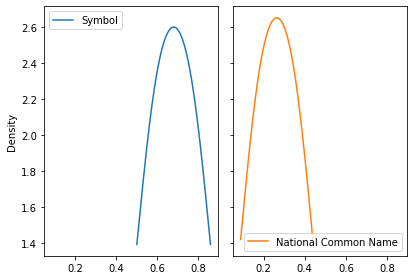

In [39]:
df = pd.DataFrame(data = np.random.random(size=(2,2)), columns = ['Symbol','National Common Name'])
df.plot(kind='kde', subplots=True, layout=(1, 2), sharex=True, sharey=True)
plt.tight_layout()

Thus we have scaled and normalized our training and testing dataset.
We are ready to move into predictive analytics part

### Data Split:
We split the data into **80% training** data and **20% test** data.

In [40]:
train,test = train_test_split(x, random_state=42, test_size=0.2)

In [41]:
train_x = train.drop('Family', axis=1) 
train_y = train['Family']

In [42]:
test_x = test.drop('Family', axis=1) 
test_y = test['Family']

## feature scaling

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.


**Standardization**: It is a very effective technique which re-scales a feature value so that it has distribution with 0 mean value and variance equals to 1.

**Normalization**: the process of scaling individual samples to have unit norm.

In [43]:
Stdscalar = StandardScaler()

train_x_std = Stdscalar.fit_transform(train_x)
test_x_std = Stdscalar.fit_transform(test_x)

**Normalizing** the data so that the data approximately follows a **Gaussian distribution** 


In [44]:
train_x_normalized = normalize(train_x_std) 
test_x_normalized = normalize(test_x_std)

Thus we have scaled and normalized our training and testing dataset.<br> We are ready to move into predictive analytics part

In [45]:
Stdscalar = StandardScaler()

x_std = Stdscalar.fit_transform(x)

x_normalized = normalize(x_std) 


### Classification and Clustering

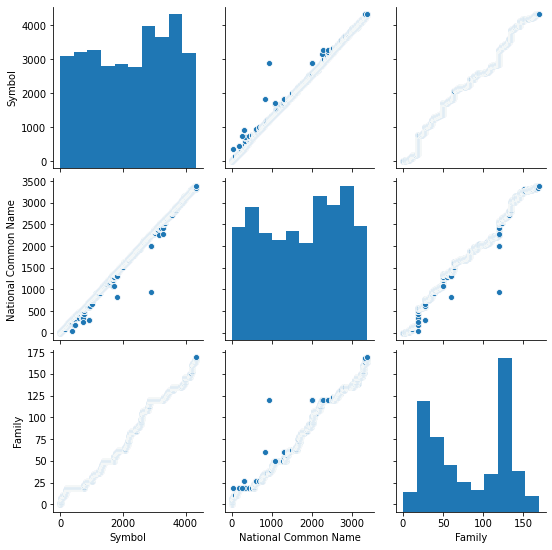

In [46]:
sns.pairplot(x)

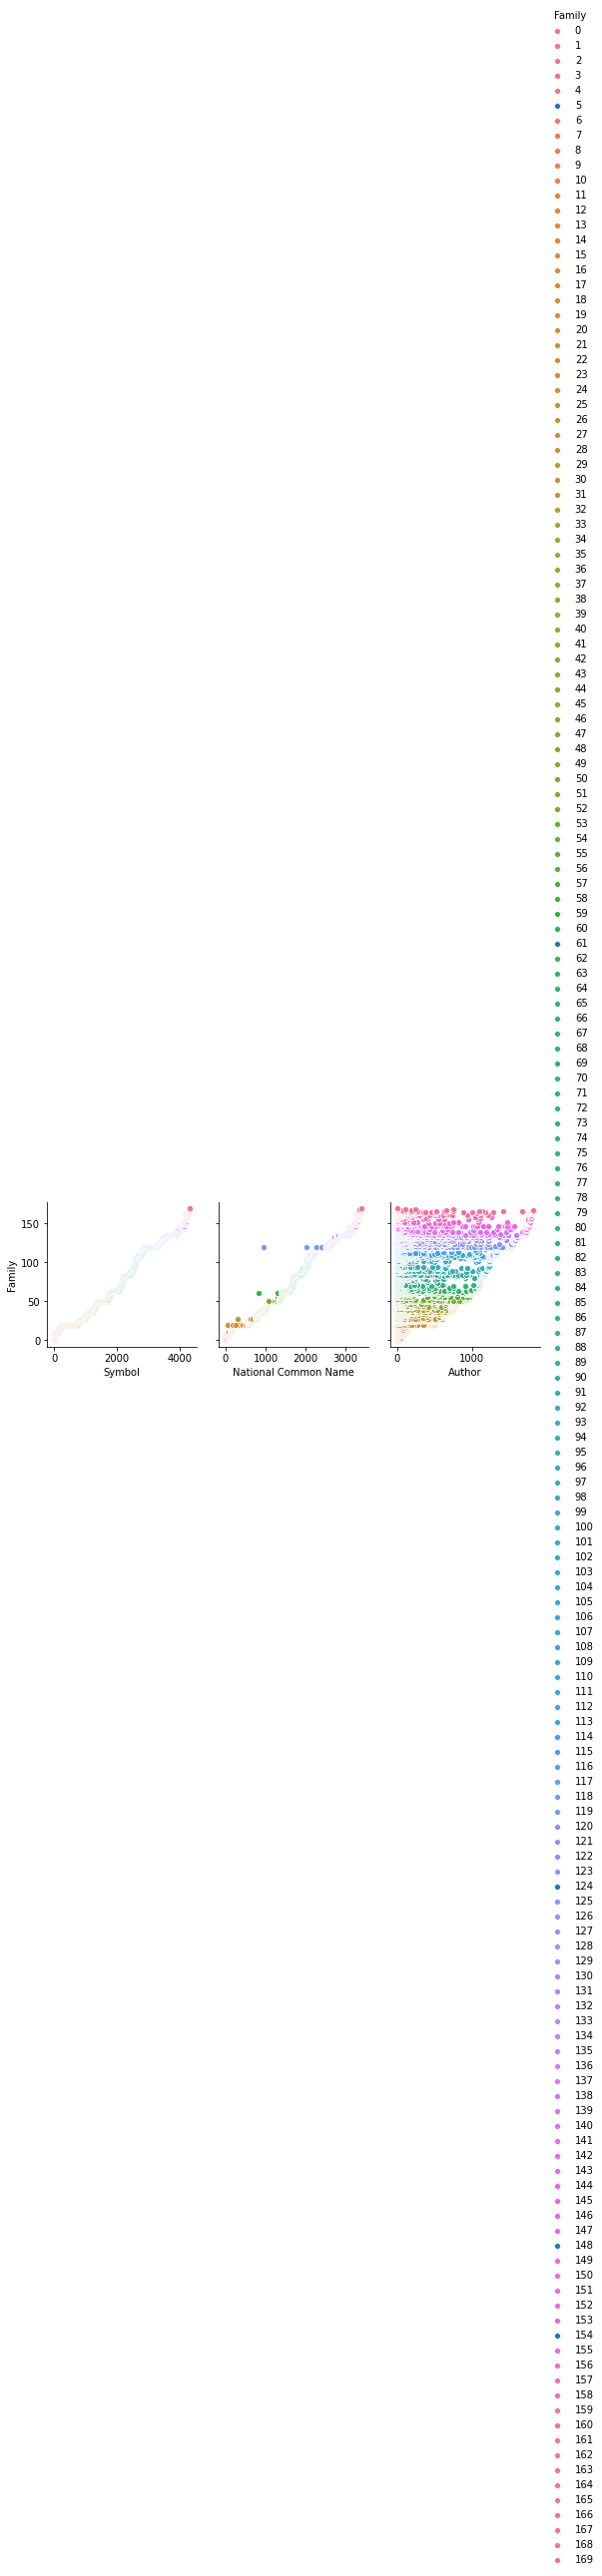

In [47]:
sns.pairplot(data_final,hue="Family", x_vars= ['Symbol', 'National Common Name', 'Author'], y_vars='Family')

### Unsupervised analytics
Unsupervised machine learning finds all kind of unknown patterns in data.

Unsupervised methods help you to find features which can be useful for categorization.
#### Hierarchical Clustering in Data Mining
A Hierarchical clustering method works via grouping data into a tree of clusters. Hierarchical clustering begins by treating every data points as a separate cluster. Then, it repeatedly executes the subsequent steps:

Identify the 2 clusters which can be closest together, and
Merge the 2 maximum comparable clusters. We need to continue these steps until all the clusters are merged together.

In Hierarchical Clustering, the aim is to produce a hierarchical series of nested clusters. A diagram called Dendrogram (A Dendrogram is a tree-like diagram that statistics the sequences of merges or splits) graphically represents this hierarchy and is an inverted tree that describes the order in which factors are merged (bottom-up view) or cluster are break up (top-down view).
#### Agglomerative:
Initially consider every data point as an individual Cluster and at every step, merge the nearest pairs of the cluster. (It is a bottom-up method). At first everydata set set is considered as individual entity or cluster. At every iteration, the clusters merge with different clusters until one cluster is formed.

In [48]:
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 

In [49]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(x_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']

#### dendrogram to understand the clusters:

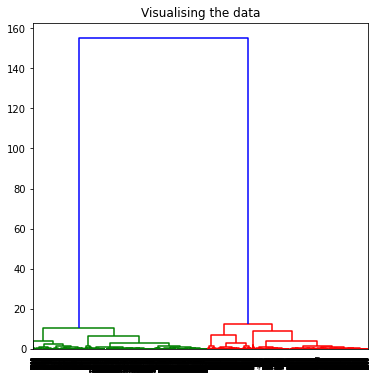

In [50]:
plt.figure(figsize =(6, 6)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward'))) 

The above image shows that the **optimal number of clusters should be 2 for the given data.**

Building and Visualizing the different clustering models for different values of k (clusters)

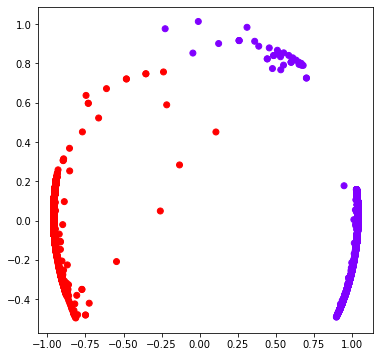

In [51]:
ac2 = AgglomerativeClustering(n_clusters = 2) 
  
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = ac2.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

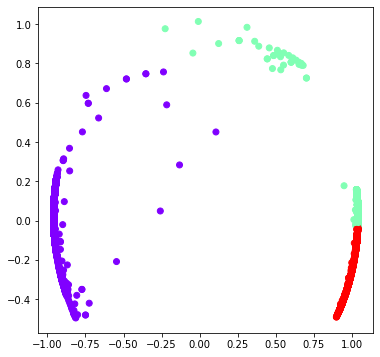

In [52]:
ac3 = AgglomerativeClustering(n_clusters = 3) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac3.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

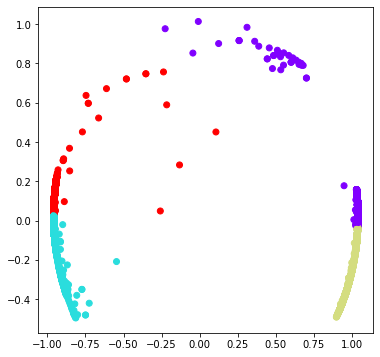

In [53]:
ac4 = AgglomerativeClustering(n_clusters = 4) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac4.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

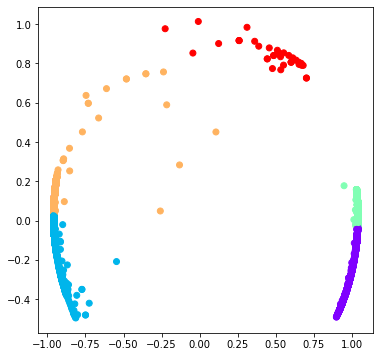

In [54]:
ac5 = AgglomerativeClustering(n_clusters = 5) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac5.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

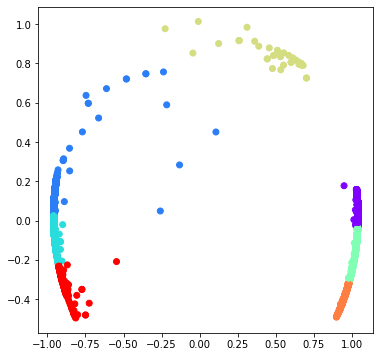

In [55]:
ac7 = AgglomerativeClustering(n_clusters = 7) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac7.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

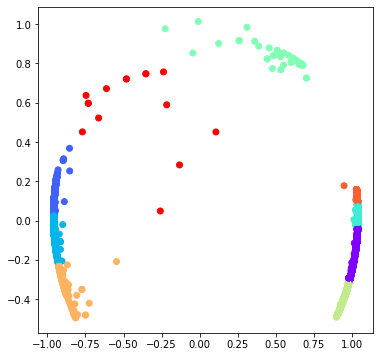

In [56]:
ac9 = AgglomerativeClustering(n_clusters = 9) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac9.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

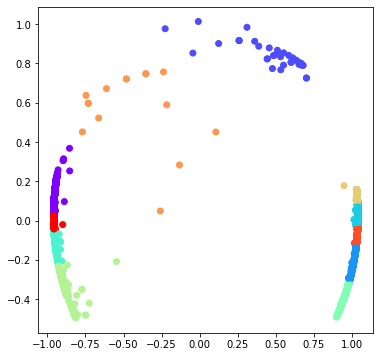

In [57]:
ac11 = AgglomerativeClustering(n_clusters = 11) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac11.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

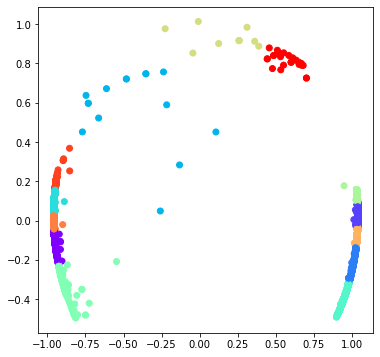

In [58]:
ac13 = AgglomerativeClustering(n_clusters = 13) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac13.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

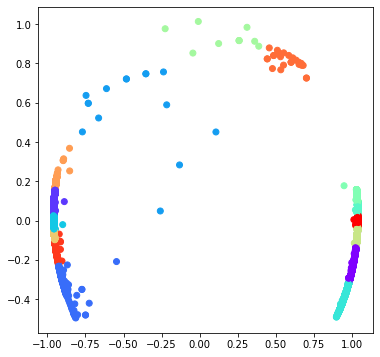

In [59]:
ac15 = AgglomerativeClustering(n_clusters = 15) 
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac15.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

#### Performance Metric:

The **silhouette score** is calculated utilizing the **mean intra- cluster distance between points, AND the mean nearest-cluster distance.** <br>For instance, a cluster with a lot of data points very close to each other (high density) AND is far away from the next nearest cluster (suggesting the cluster is very unique in comparison to the next closest), will have a strong silhouette score. A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. **Silhouette scores of 0 suggest overlapping clusters**. <br><br> The Silhouette Coefficient tells us how well-assigned each individual point is. If S(i) is close to 0, it is right at the inflection point between two clusters. If it is **closer to -1, then we would have been better off assigning it to the other cluster**. If **S(i) is close to 1, then the point is well-assigned** and can be interpreted as belonging to an ‘appropriate’ cluster.

We now determine the optimal number of clusters using the Silhouette Scores.


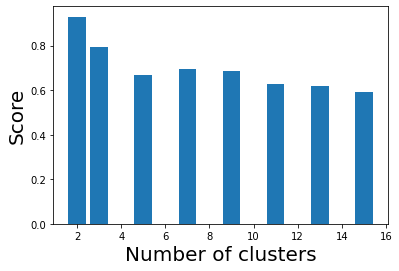

In [60]:
k = [2, 3, 5, 7, 9, 11, 13,15] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_principal, ac2.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac3.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac5.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac7.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac9.fit_predict(X_principal)))
silhouette_scores.append( 
        silhouette_score(X_principal, ac11.fit_predict(X_principal)))
silhouette_scores.append( 
        silhouette_score(X_principal, ac13.fit_predict(X_principal)))
silhouette_scores.append( 
        silhouette_score(X_principal, ac15.fit_predict(X_principal)))
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Score', fontsize = 20) 
plt.show() 

So the Highest value of Silhouette Score is shown by the model which has only **two clusters**. Thus the Hierarchical clustering model with two clusters is **optimal** to cluster our data properly.

### Supervised analytics :

**SVM**:


Support vector machine is highly preferred by many as it produces significant accuracy with less computation power. SVM can be used for both regression and classification tasks.

We can use a multiclass SVM classifier on our dataset:

In [61]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_x_normalized, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
clf.score(test_x_normalized,test_y)

0.23753546817997567

### Conclusion
We have taken the plants dataset which has all **Categorical** data. Then performed Data analysis and Data cleaning which include Process Missing values, Feature Encoding, Feature Selection and Feature Scaling. Later we have employeed Unsupervised algorithms like Hierarchical Based Clustering to cluster similar type instances into similar groups. Then we analyzied how good our models are clustering with the help of performance metrices like Silhouette Score.<br>
The supervised and unsupervised algorithms do not seem to ably differentiate the classes in the 'Family' target variable.

A possible reason could be that large number of categories (169 classes) in 'Family' variable. The categories could be very similar to each other and a lack of a differentiating factor can be attributed to the poor classification performance.

## Itemset Mining:

In [87]:
df = pd.read_csv('plants1.csv')
df.head()
print(df.shape[0])

12333


In [88]:
transaction = []
for row in range(df.shape[0]):
    dict_ = set()
    for col in range(df.shape[1]):
        x = df.iloc[row][col]
        dict_.add(x)
    transaction.append(dict_)

In [89]:
transaction_subset = []
for row in range(0,150):
    dict_ = set()
    for col in range(df.shape[1]):
        x = df.iloc[row][col]
        dict_.add(x)
    transaction_subset.append(dict_)
print(transaction_subset)

[{0, 1, 2}, {0, 2}, {0, 2, 3}, {0, 2, 3}, {0, 2, 3}, {0, 1}, {0, 1, 2}, {0, 3, 4}, {0, 3, 5}, {0, 3}, {0, 3, 6}, {0, 3}, {0, 3}, {0, 3}, {1, 4, 7}, {1, 2, 5}, {8, 2, 6}, {9, 2, 7}, {10, 2, 7}, {8, 1, 2}, {8, 9, 2, 11}, {9, 2, 12, 7}, {9, 2, 13, 7}, {9, 2, 13, 7}, {8, 9, 2, 14}, {8, 10, 2, 15}, {8, 16, 10, 2}, {8, 17, 10, 2}, {8, 2, 10, 18}, {8, 19, 2, 11}, {9, 2, 11, 20}, {9, 2, 12, 21}, {8, 2, 11, 12}, {10, 2, 12, 22}, {8, 2, 12}, {10, 2, 12, 23}, {24, 2, 11, 12}, {1, 10, 2, 13}, {1, 2, 11, 14}, {25, 2, 11, 14}, {1, 2, 12, 15}, {2, 26, 11, 15}, {16, 2, 27, 12}, {16, 2, 28, 13}, {16, 2, 11, 12}, {16, 24, 2, 13}, {17, 2, 13, 1}, {17, 2, 29, 14}, {17, 2, 14, 30}, {17, 2, 14, 31}, {24, 17, 2, 13}, {32, 18, 2, 14}, {33, 2, 19, 14}, {2, 34, 19, 14}, {35, 2, 19, 14}, {11, 2, 10, 19}, {2, 19, 13, 31}, {2, 19, 36, 14}, {2, 20, 37, 15}, {16, 3, 21, 38}, {1, 18, 3, 21}, {18, 3, 21, 39}, {17, 3, 22, 1}, {16, 1, 3, 23}, {24, 1, 18, 4}, {25, 19, 4, 1}, {1, 26, 20, 5}, {1, 5, 27, 21}, {40, 5, 27, 21

## FMI

### apriori

In [90]:
import os, operator
from collections import defaultdict
from itertools import combinations, chain


class Apriori:
	"""
	Parameters
	----------
	minSupport: float
				Minimum support value for a transaction
				to be called interesting.
	minConfidence: float
				Minimum confidence for a rule to be called
				interesting.
	support_count: collection.defaultdict(int)
				Contains support count of itemsets.
				{
					frozenset(): int,
				}
				frozenset(): set of items
				int: support count of the itemset
	"""

	def __init__(self, minSupport=0.02, minConfidence=0.45):
		self.support_count = defaultdict(int)
		self.minSupport = minSupport
		self.minConfidence = minConfidence


	def read_transactions_from_file(self, transaction_file):
		"""
		Parameters
		----------
		transaction_file: csv file

		Return Type
		-----------
		List of transactions as read from file.
		Each transaction is a set of items.
			[{a, b, c}, {b, d, p, q}, {p, e}, .....]
			{a, b, c} - 1st itemset (3-itemset)
			{b, d, p, q} - 2nd itemset (4-itemset)
			{p, e} - 3rd itemset (2-itemset)
			...
		"""
		with open (transaction_file, 'r') as infile:
			transactions = [set(line.rstrip('\n').split(',')) 
							for line in infile]
		
			return transactions


	def get_one_itemset(self, transactions):
		"""
		Parameters
		----------
		List of transactions. Each transaction 
		is a set of items.
			[{a, b, c}, {b, d, p, q}, {p, e}, .....]
		
			{a, b, c} - 1st itemset (3-itemset)
			{b, d, p, q} - 2nd itemset (4-itemset)
			{p, e} - 3rd itemset (2-itemset)
			...
		
		Return Type
		-----------
		one_itemset: set of unique items;
			{
				frozenset({'a'}), frozenset({'b'}), frozenset({'c'}), 
				frozenset({'d'}), frozenset({'e'}), frozenset({'p'}), 
				frozenset({'q'})
			}
		"""
		one_itemset = set()
		for transaction in transactions:
			for item in transaction:
				one_itemset.add(frozenset([item]))
		
		return one_itemset


	def self_cross(self, Ck, itemset_size):
		"""
		Parameters
		----------
		Ck: Candidate itemset
			a set of k-itemsets
			Size if each itemset in Ck is k(=itemset_size-1)
		itemset_size: int
			Required size of each itemset in resulting set(=k+1)
		Ck:
		{
			frozenset({'book', 'pen'}),
			frozenset({'book', 'dog'}),
			frozenset({'ox', 'coke'}),
			...
		} 
		for a 2-itemset
		
		Return Type
		-----------
		Ck_plus_1: Candidate itemset + 1
			a set of (k+1)-itemsets
		
		Ck_plus_1:
		{
			frozenset({'book', 'pen', 'dog'}),
			frozenset({'book', 'dog', 'ox'}),
			frozenset({'book', 'coke', 'dog'}),
			...
		}
		"""
		Ck_plus_1 = {itemset1.union(itemset2) 
					for itemset1 in Ck for itemset2 in Ck 
					if len(itemset1.union(itemset2)) == itemset_size}
		return Ck_plus_1


	def prune_Ck(self, Ck, Lk_minus_1, itemset_size):
		"""
		Parameters
		----------
		Ck: Candidate itemset
			a set of k-itemsets(k=itemset_size)
		Lk_minus_1: set
			a set of (k-1)-itemsets
		itemset_size: int
			(= k)
		Ck:
		{
			frozenset({'book', 'dog', 'copper'}),
			frozenset({'book', 'dog', 'water'}),
		}
		Ck_minus_1:
		{
			frozenset({'book', 'dog'}),
			frozenset({'book', 'copper'}),
			frozenset({'dog', 'copper'})
			frozenset({'book', 'water'}),
			frozenset({'dog', 'water'}),
		}
		Lk_minus_1:
		{
			frozenset({'book', 'copper'}),
			frozenset({'book', 'dog'}),
			frozenset({'book', 'water'}),
			frozenset({'water', 'dog'})
		}
		Returns
		-------
		Ck_: set
			a set of k-itemsets
		Ck_: 
		{
			frozenset({'book', 'dog', 'water'})
		} those Ck's whose Ck_minus_1's are in Lk_minus_1
		
		"""
		Ck_ = set()
		for itemset in Ck:
			Ck_minus_1 = list(combinations(itemset, itemset_size-1))
			flag = 0
			for subset in Ck_minus_1:
				if not frozenset(subset) in Lk_minus_1:
					flag = 1
					break
			if flag == 0:
				Ck_.add(itemset)
		return Ck_


	def get_min_supp_itemsets(self, Ck, transactions):
		"""
		Parameters
		----------
		Ck: set
			a set of k-itemsets
		Transactions: list
			list of transactions. Each transaction is
			a set of items.
			[{a, b, c}, {b, d, p, q}, {p, e}, .....]
		Returns
		-------
		Lk: set
			a set of k-itemsets
			set of itemsets whose support is > minSupport
		"""
		temp_freq = defaultdict(int)
		
		# update support count of each itemset
		for transaction in transactions:
			for itemset in Ck:
				if itemset.issubset(transaction):
					temp_freq[itemset] += 1
					self.support_count[itemset] += 1

		N = len(transactions)
		Lk = [itemset for itemset, freq in temp_freq.items() 
					if freq/N > self.minSupport]
		return set(Lk)


	def apiori(self, transactions):
		"""
		Parameters
		----------
		transactions: list
			list of transactions. Each transaction is
				a set of items.
				[{a, b, c}, {b, d, p, q}, {p, e}, .....]
		Returns
		-------
		K_itemsets: dict
		{
			1: {frozenset({'dog'}), frozenset({'ox'}), ....}
			2: {frozenset({'dog', 'water'}), frozenset({'book', 'copper'}), .....}
			3: {frozenset({'dog', 'ox', 'gold'}), frozenset({'water', 'dog', ox}), ...}
		}
			key: value
			int: set of frozensets of size = value of key
			
			each itemset in K_itemset has support > minSupport
		"""
		K_itemsets = dict()
		Ck = self.get_one_itemset(transactions)
		Lk = self.get_min_supp_itemsets(Ck, transactions)
		k = 2
		while len(Lk) != 0:
			K_itemsets[k-1] = Lk
			Ck = self.self_cross(Lk, k)
			print(k, len(Ck))
			Ck = self.prune_Ck(Ck, Lk, k)
			print(k, len(Ck))
			Lk = self.get_min_supp_itemsets(Ck, transactions)
			print(k, len(Lk))
			k += 1

		return K_itemsets


	def subsets(self, iterable):
		"""
		Parameters
		----------
		iterable: an itearble container like set
		Returns
		-------
		subsets_: list powerset of elements in the iterable container
			[
				frozenset(),
				frozenset({a}), frozenset({b}),
				frozenset({a, b})  
			] if iterable is like {a, b}
		"""
		list_ = list(iterable)
		subsets_ = chain.from_iterable(combinations(list_, len) 
				for len in range(len(list_)+1))
		subsets_ = list(map(frozenset, subsets_))
		
		return subsets_


	def get_rules(self, K_itemsets):
		"""
		Parameters
		----------
		K_itemset: dict
			{key: value}
			{int: set of frozensets of size = value of key}
			
			each itemset in K_itemset has support > minSupport
		Returns
		-------
		rules: list of tuples
			Confidence of each returned rule is > minConfidence
		rule: left -> right
		tuple: (left, right, confidence of rule)
		"""
		rules = list()
		for key, k_itemset in K_itemsets.items():
			if key > 1:
				for itemset in k_itemset:
					sub_itemsets = \
					{subset for subset in self.subsets(itemset) 
						if (subset != set() and len(subset) != len(itemset))}
					for subset in sub_itemsets:
						left = subset
						right = itemset.difference(subset)
						confidence = self.support_count[itemset]/self.support_count[left]
						if (confidence > self.minConfidence):
							rules.append((list(left), list(right), confidence))

		rules.sort(key=operator.itemgetter(2), reverse=True)
		return rules


	def write_info(self, K_itemsets, rules, transactions_count):
		"""
		Writes the rules and frequent itemsets with their 
		support and confidence to a file.
		"""
		N = transactions_count
		main_dir = './results/'
		if not os.path.exists(main_dir):
			os.makedirs(main_dir)

		outfile_path = './results/s='+str(self.minSupport)+' c='+str(self.minConfidence)
		with open (outfile_path, 'w') as outfile:
			outfile.write('Frequnet Itemsets:')
			tot_itemset_count = 0
			for key, values in K_itemsets.items():
				outfile.write('\n'+str(key)+'-itemsets:\n')
				count = 0
				for value in values:
					support = self.support_count[value]/N
					support_ct = self.support_count[value]
					count += 1
					tot_itemset_count += 1
					outfile.write(str(list(value))+' | support: '+str(support_ct)+'\n')
				outfile.write('Count: '+str(count)+'\n\n')

			outfile.write('Total number of frequent itemset(s): '+str(tot_itemset_count)+'\n')
			outfile.write('\n\nRules:\n')

			for rule in rules:
				support_l = self.support_count[frozenset(rule[0])]
				support_r = self.support_count[frozenset(rule[1])]
				outfile.write(str(rule[0])+'('+str(support_l)+')'+' -> '+str(rule[1])+ \
							'('+str(support_r)+')'+' | confidence: '+str(rule[2])+'\n')
			outfile.write('\nTotal number of rules: '+str(len(rules))+'\n')


In [91]:
in_transaction_file = 'plants1.csv'  # For Given Plants Dataset
#in_transaction_file = '/content/groceries.csv' # For Groceries 

minSupport=0.03
minConfidence=0.0001
ap = Apriori(minSupport,minConfidence)
transactions = ap.read_transactions_from_file(in_transaction_file)
K_itemsets = ap.apiori(transactions)
rules = ap.get_rules(K_itemsets)
ap.write_info(K_itemsets, rules, len(transactions))

cwd = os.getcwd()
dirname = os.path.dirname(cwd+'/results/s='+str(minSupport)+' c='+str(minConfidence))
if not os.path.exists(dirname):
    os.makedirs(dirname)

f=open(cwd+'/results/s='+str(minSupport)+' c='+str(minConfidence), "r")
contents = f.read()
print(contents)

2 28
2 28
2 0
Frequnet Itemsets:
1-itemsets:
['19'] | support: 1674
['50'] | support: 780
['27'] | support: 413
['3'] | support: 586
['120'] | support: 1408
['63'] | support: 495
['135'] | support: 1118
['1'] | support: 1501
Count: 8

Total number of frequent itemset(s): 8


Rules:

Total number of rules: 0



### CFI

#### ACLOSE

In [92]:
from itertools import combinations

def generateCandidateItemsets(level_k, level_frequent_itemsets):
        """ Generate and prune the candidate itemsets for next level using the frequent itemsets of the current level
        Parameters
        ----------
        level_k : int
                The current level number
        level_frequent_itemsets : list of lists
                The list of frequent itemsets of current level
        Returns
        -------
        list of lists
                The candidate itemsets of the next level
        """

        n_frequent_itemsets = len(level_frequent_itemsets)

        candidate_frequent_itemsets = []

        for i in range(n_frequent_itemsets):
                j = i+1
                while (j<n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k-1] == level_frequent_itemsets[j][:level_k-1]):

                        candidate_itemset = level_frequent_itemsets[i][:level_k-1] + [level_frequent_itemsets[i][level_k-1]] + [level_frequent_itemsets[j][level_k-1]]
                        candidate_itemset_pass = False

                        if level_k == 1:
                                candidate_itemset_pass = True

                        elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
                                candidate_itemset_pass = True

                        elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k-2)):
                                candidate_itemset_pass = True

                        if candidate_itemset_pass:
                                candidate_frequent_itemsets.append(candidate_itemset)

                        j += 1

        return candidate_frequent_itemsets


def generateClosures(transactions, generators):
        """ Generate the closures of the generators
        transactions : list of sets
                The list of transactions
        generators : lists of lists
                The list of generator itemsets whose closures need to be computed
        Returns
        -------
        list of sets
                The list of closures mapped from the generators
        """

        # The indices of transactions where generators occur
        generators_trans_indices = [[] for _ in range(len(generators))]

        for trans_index, transaction in enumerate(transactions):
                for generator_index, generator in enumerate(generators):
                        if all(_item in transaction for _item in generator):
                                generators_trans_indices[generator_index].append(trans_index)

        generators_closures = []
        for generator_trans_indices in generators_trans_indices:

                if generator_trans_indices:
                        closure = transactions[generator_trans_indices[0]].copy()

                else:
                        closure = set()

                for trans_index in generator_trans_indices[1:]:
                        closure.intersection_update(transactions[trans_index])
                generators_closures.append(closure)

        return generators_closures


def AClose(transactions, min_support, return_support_counts=False):
        """ Extract the closed frequent itemsets from the transactions
        Returns the closed closed frequent itemsets mined from the transactions that have a support greater than the minimum
        threshold. There is one optional output in addition to the closed frequent itemsets: The support counts of the
        closed frequent itemsets mined.
        Parameters
        ----------
        transactions : list of sets
                The list of transactions
        min_support : int
                The minimum support threshold
        return_support_counts : bool, optional
                If true, also return the support count of each itemset
        Returns
        -------
        closed_frequent_itemsets : list of sets
                closed frequent itemsets mined from the transactions that have support greater than the minimum threshold
        support_counts : list of integers, optional
                The support count of the closed frequent itemsets mined. Only provided if `return_support_counts` is True.
        """

        items = set()
        for transaction in transactions:
                items.update(transaction)
        items = sorted(list(items))

        # The list of all generator from whose closure we can derive all CFIs
        generators = []

        level_k = 1

        prev_level_freq_itemsets_cnts = [] # Level 0: Frequent Itemsets and its support counts
        candidate_frequent_itemsets = [[item] for item in items] # Level 1: Candidate Itemsets

        while candidate_frequent_itemsets:

                print("LEVEL {}:".format(level_k))

                # Count the support of all candidate frequent itemsets
                candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)

                for transaction in transactions:
                        for i, itemset in enumerate(candidate_frequent_itemsets):
                                if all(_item in transaction for _item in itemset):
                                        candidate_freq_itemsets_cnts[i] += 1

                print("C{}: ".format(level_k), end='')
                for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Generate the frequent itemsets of level k by pruning infrequent itemsets
                level_frequent_itemsets_cnts = [(itemset,support) for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]

                print("L{}: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Prune the frequent itemsets of level k which have same support as some frequent subset in level k-1
                print("Itemsets Pruned from L{}: ".format(level_k), end='')
                for level_freq_itemset, level_freq_itemset_sup in level_frequent_itemsets_cnts.copy():
                        for prev_level_freq_itemset, prev_level_freq_itemset_sup in prev_level_freq_itemsets_cnts:

                                # If the previous level itemset is a subset of current level itemset and both have same support
                                if all(_item in level_freq_itemset for _item in prev_level_freq_itemset) and prev_level_freq_itemset_sup == level_freq_itemset_sup:
                                        print(level_freq_itemset, end=', ')
                                        level_frequent_itemsets_cnts.remove((level_freq_itemset, level_freq_itemset_sup))
                                        break
                print()

                print("L{} After Pruning: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Generate candidate sets of level k+1 using frequent itemsets of level k
                level_frequent_itemsets = [itemset for itemset,support in level_frequent_itemsets_cnts]
                candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)
                generators.extend(level_frequent_itemsets)

                level_k += 1

                prev_level_freq_itemsets_cnts = level_frequent_itemsets_cnts
                print()

        # Generate the closure of the generators
        generators_closures = generateClosures(transactions, generators)

        closed_frequent_itemsets = []

        # Remove the duplicates from the list of closures
        for generator_closure in generators_closures:
                if generator_closure not in closed_frequent_itemsets:
                        closed_frequent_itemsets.append(generator_closure)

        if return_support_counts == True:
            # Generate count of cfi's
            closed_frequent_itemsets_cnts = [0]*len(closed_frequent_itemsets)
            for transaction in transactions:
                    for i, itemset in enumerate(closed_frequent_itemsets):
                            if all(_item in transaction for _item in itemset):
                                closed_frequent_itemsets_cnts[i] += 1
            return closed_frequent_itemsets, closed_frequent_itemsets_cnts
        else:
            return closed_frequent_itemsets

In [93]:
CFIs, CFI_cnts = AClose(transaction_subset, 3, return_support_counts=True)

print("Closed Frequent Itemsets (CFIs)")
print("-------------------------------")
for itemset, cnt in zip(CFIs, CFI_cnts):
    print("Itemset: {} Support count: {}".format(itemset, cnt))

        

LEVEL 1:
C1: [0] -> 14, [1] -> 28, [2] -> 50, [3] -> 17, [4] -> 5, [5] -> 7, [6] -> 5, [7] -> 58, [8] -> 36, [9] -> 8, [10] -> 9, [11] -> 10, [12] -> 10, [13] -> 8, [14] -> 12, [15] -> 4, [16] -> 7, [17] -> 7, [18] -> 5, [19] -> 8, [20] -> 3, [21] -> 8, [22] -> 4, [23] -> 5, [24] -> 6, [25] -> 8, [26] -> 3, [27] -> 6, [28] -> 5, [29] -> 8, [30] -> 11, [31] -> 7, [32] -> 8, [33] -> 8, [34] -> 12, [35] -> 5, [36] -> 7, [37] -> 5, [38] -> 9, [39] -> 6, [40] -> 4, [41] -> 6, [42] -> 4, [43] -> 6, [44] -> 22, [45] -> 4, [46] -> 9, [47] -> 4, [48] -> 4, [49] -> 3, [50] -> 3, [51] -> 5, [52] -> 5, [53] -> 5, [54] -> 6, [55] -> 2, [56] -> 3, [57] -> 4, [58] -> 1, [59] -> 7, [60] -> 1, [61] -> 1, [62] -> 1, [63] -> 2, [64] -> 2, [65] -> 1, [66] -> 1, [67] -> 1, [68] -> 2, [69] -> 1, [70] -> 4, [71] -> 1, [72] -> 2, [73] -> 1, [74] -> 1, [75] -> 1, [76] -> 1, 
L1: [0] -> 14, [1] -> 28, [2] -> 50, [3] -> 17, [4] -> 5, [5] -> 7, [6] -> 5, [7] -> 58, [8] -> 36, [9] -> 8, [10] -> 9, [11] -> 10, [12]

Itemset: {46} Support count: 9
Itemset: {47} Support count: 4
Itemset: {48} Support count: 4
Itemset: {49} Support count: 3
Itemset: {50} Support count: 3
Itemset: {51} Support count: 5
Itemset: {52} Support count: 5
Itemset: {53} Support count: 5
Itemset: {54} Support count: 6
Itemset: {56} Support count: 3
Itemset: {57, 7} Support count: 4
Itemset: {59, 7} Support count: 7
Itemset: {8, 70} Support count: 4
Itemset: {0, 1} Support count: 3
Itemset: {0, 2} Support count: 6
Itemset: {0, 3} Support count: 10
Itemset: {1, 2} Support count: 8
Itemset: {1, 3} Support count: 3
Itemset: {1, 4} Support count: 3
Itemset: {1, 5} Support count: 3
Itemset: {1, 7} Support count: 3
Itemset: {8, 1} Support count: 9
Itemset: {0, 2, 3} Support count: 3
Itemset: {2, 7} Support count: 5
Itemset: {8, 2} Support count: 11
Itemset: {2, 14} Support count: 11
Itemset: {16, 2} Support count: 5
Itemset: {17, 2} Support count: 6
Itemset: {2, 19} Support count: 7
Itemset: {24, 2} Support count: 3
Itemset: {3, 21}

### MFI

In [96]:
import numpy as np
from functools import lru_cache

class TransVerticalBitmaps:
	""" 
	Parameters
	----------
	transactions : list of sets
		The list of transactions
	Attributes
	----------
	transactions : list of sets
		The list of transactions
	n_transactions : int
		The number of transactions
	items : list
		The list of all items in sorted order
	items_vertical_bitmaps : dict
		The dictionary of vertical bitmap representation of transactions indexed by item
	"""

	def __init__(self, transactions):

		self.transactions = transactions
		self.n_transactions = len(self.transactions)

		# Extract the list of items in the transactions
		items = set()
		for transaction in self.transactions:
			items.update(transaction)
		self.items = sorted(items)

		self.items_vertical_bitmaps = {item:np.zeros(shape=(self.n_transactions,), dtype=np.bool) for item in self.items}

		for i_transaction, transaction in enumerate(self.transactions):
			for item in transaction:
				self.items_vertical_bitmaps[item][i_transaction] = True


	@lru_cache(maxsize=32)
	def compVerticalBitmap(self, itemset):
		""" Compute the vertical bitmap of the given itemset
		
		Parameters
		----------
		itemset : tuple
			The tuple of items (or itemset) for which support is to be counted
		Returns
		-------
		np.array(bool)
			Vertical bitmap of transactions in the which itemset is present
		"""
		
		if len(itemset) == 1:
			item = itemset[0]
			return self.items_vertical_bitmaps[item]

		else:
			last_item = itemset[-1]
			return self.compVerticalBitmap(itemset[:-1])&self.items_vertical_bitmaps[last_item]


	def countSupport(self, itemset):
		""" Count the support of the itemset in the transactions 
		Parameters
		----------
		itemset : tuple
			The tuple of items for which support is to be counted
		Returns
		-------
		int
			The support count of the itemset in the transactions
		"""
		
		itemset_vertical_bitmap = self.compVerticalBitmap(itemset)
		itemset_support_count = np.count_nonzero(itemset_vertical_bitmap)

		return itemset_support_count



class MafiaNode:
	""" A node in the MAFIA candidate itemset tree 
	
	Parameters
	----------
	head : set
		The set of all items in head of the node
	tail : tuple
		The tuple of all items in tail of the node
	support_count : int optional(default=None)
		The support count of head of the node
	Attributes
	----------
	head : set
		The set of all items in head of the node
	tail : tuple
		The tuple of all items in tail of the node
	support_count : int
		The support count of head of the node
	Notes
	-----
		The :attr:`head` is of type tuple as opposed to set or list since it is passed to :meth:`compVerticalBitmap`
		of :class:`transactions` that caches results and therefore requires the inputs to **hashable**.
	"""

	def __init__(self, head, tail, support_count=None):
		self.head = head
		self.tail = tail.copy()
		self.support_count = support_count


def _mafiaAlgorithm(current_node, MFIs, transactions, min_support_count):

	# HUTMFI Pruning - Prune the subtree, if the HUT of the node has any superset in MFI
	head_union_tail = current_node.head + tuple(current_node.tail)
	if any(all(item in mfi for item in head_union_tail) for mfi in MFIs):
		return

	# Count the support of all children of the node
	node_children_support_cnts = [( item ,transactions.countSupport(current_node.head + (item,)) ) for item in current_node.tail]
	# Extract the frequent children of the node and their support counts
	node_freq_children_sup_cnts = [(item, support_count) for item, support_count in node_children_support_cnts if support_count >= min_support_count]

	node_children_items_parent_eq = [] # The items in tail with same support as parent
	node_tail_items_sup_cnts	= [] # The items in node's tail (except parent equivalence items) sorted by desc support

	for item, support_count in node_freq_children_sup_cnts:
		if support_count == current_node.support_count:
			node_children_items_parent_eq.append(item)
		else:
			node_tail_items_sup_cnts.append((item, support_count))

	# Sort the items in the trimmed tail by increasing support
	node_tail_items_sup_cnts.sort(key=lambda x:x[1])
	node_tail_items = [item for item, support in node_tail_items_sup_cnts]

	current_node.head += tuple(node_children_items_parent_eq)
	current_node.tail = node_tail_items

	is_leaf = not bool(current_node.tail)

	for i, item in enumerate(current_node.tail):
		new_node_head = current_node.head + (item,)
		new_node_tail = current_node.tail[i+1:]
		new_node_support_cnt = node_tail_items_sup_cnts[i][1]
		new_node = MafiaNode(new_node_head, new_node_tail, new_node_support_cnt)

		is_hut = (i == 0) # if i is the first element in the tail
		_mafiaAlgorithm(new_node, MFIs, transactions, min_support_count)

	# if current node is a leaf and no superset of current node head in MFIs
	if is_leaf and current_node.head and not any(all(item in mfi for item in current_node.head) for mfi in MFIs):
		MFIs.append(set(current_node.head))


def mafiaAlgorithm(transactions, min_support_count):
	""" Extract the MFIs (Maximal Frequent Itemsets) from transactions with min support count using MAFIA Algorithm
	Parameters
	----------
	transactions : list of sets
		The list of transactions
	min_support_count : int
		The minimum support count threshold
	Returns
	-------
	list of sets
		The list of all maximal frequent itemsets
	"""

	transactions_vertical_bitmaps = TransVerticalBitmaps(transactions)
	MFIs = []

	# Create the root node of MAFIA candidate itemset tree
	mafia_cand_itemset_root = MafiaNode(tuple(), transactions_vertical_bitmaps.items, transactions_vertical_bitmaps.n_transactions)

	# Perform the MAFIA algorithm
	_mafiaAlgorithm(mafia_cand_itemset_root, MFIs, transactions_vertical_bitmaps, min_support_count)
	return MFIs


In [97]:

min_support_count = 3

MFIs = mafiaAlgorithm(transaction_subset, min_support_count)

# Print the list of all maximal frequent itemsets (MFIs)
print("Maximal Frequent Itemsets (MFIs)")
for mfi in MFIs:
    print(mfi)

Maximal Frequent Itemsets (MFIs)
{20}
{26}
{49}
{50}
{56}
{2, 15}
{22}
{40}
{42}
{45, 7}
{8, 47}
{48, 7}
{57, 7}
{8, 70}
{1, 4}
{6}
{18}
{23}
{28}
{35, 7}
{37, 7}
{8, 51}
{8, 52, 44}
{8, 53}
{24, 2}
{21, 27, 5}
{7, 39}
{8, 41}
{43, 7}
{54, 7}
{1, 5}
{16, 2}
{17, 2, 14}
{7, 38, 31}
{36, 44, 7}
{59, 38, 7}
{34, 59, 7}
{9, 2, 7}
{2, 13}
{2, 19, 14}
{3, 21}
{25, 30, 7}
{33, 29, 7}
{32, 38, 7}
{8, 10, 2}
{8, 46}
{2, 11, 12}
{8, 2, 11}
{34, 44, 7}
{0, 1}
{0, 2, 3}
{1, 3}
{1, 7}
{1, 2}
{8, 1}


## MFCS

In [98]:
from itertools import combinations

def generateMFCS(MFCS, infrequent_itemsets):
	""" Generate the updated MFCS by modifing itemsets that have infrequent itemsets as its subset
	Parameters
	----------
	MFCS : list of lists
		The list of Maximal Frequent Candidate Sets
	infrequent_itemsets : list of lists
		The list of infrequent itemsets
	Returns
	-------
	lists of lists
		Updated MFCS
	"""

	MFCS = MFCS.copy()

	for infrequent_itemset in infrequent_itemsets:

		for MFCS_itemset in MFCS.copy():
			
			# If infrequent itemset is a subset of MFCS itemset
			if all(_item in MFCS_itemset for _item in infrequent_itemset):
				MFCS.remove(MFCS_itemset)
				
				for item in infrequent_itemset:
					updated_MFCS_itemset = MFCS_itemset.copy()
					updated_MFCS_itemset.remove(item)

					if not any(all(_item in _MFCS_itemset for _item in updated_MFCS_itemset) for _MFCS_itemset in MFCS):
						MFCS.append(updated_MFCS_itemset)

	return MFCS


def pruneCandidatesUsingMFS(candidate_itemsets, MFS):
	""" Prune the candidate itemsets that are subsets of MFS itemsets
	Parameters
	----------
	candidate_itemsets : lists of lists
		The list of candidate itemsets
	MFS : lists of lists
		The list of Maximal Frequent Itemsets
	Returns
	-------
	lists of lists
		The list of candidate itemsets with are not subsets of any itemset in MFS
	"""

	candidate_itemsets = candidate_itemsets.copy()

	for itemset in candidate_itemsets.copy():
		if any(all(_item in _MFS_itemset for _item in itemset) for _MFS_itemset in MFS):
			candidate_itemsets.remove(itemset)

	return candidate_itemsets


def generateCandidateItemsets(level_k, level_frequent_itemsets):
	""" Generate and prune the candidate itemsets for next level using the frequent itemsets of the current level 
	
	Parameters
	----------
	level_k : int
		The current level number
	level_frequent_itemsets : list of lists
		The list of frequent itemsets of current level
	Returns
	-------
	list of lists
		The candidate itemsets of the next level
	"""

	n_frequent_itemsets = len(level_frequent_itemsets)

	candidate_frequent_itemsets = []

	for i in range(n_frequent_itemsets):
		j = i+1
		while (j<n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k-1] == level_frequent_itemsets[j][:level_k-1]):
			
			candidate_itemset = level_frequent_itemsets[i][:level_k-1] + [level_frequent_itemsets[i][level_k-1]] + [level_frequent_itemsets[j][level_k-1]]
			candidate_itemset_pass = False

			if level_k == 1:
				candidate_itemset_pass = True
				
			elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
				candidate_itemset_pass = True

			elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k-2)):
				candidate_itemset_pass = True
				
			if candidate_itemset_pass:
				candidate_frequent_itemsets.append(candidate_itemset)

			j += 1

	return candidate_frequent_itemsets


def pruneCandidatesUsingMFCS(candidate_itemsets, MFCS):
	""" Prune the candidate itemsets that are not subsets of any itemsets in current MFCS 
	Parameters
	----------
	candidate_itemsets : lists of lists
		The list of candidate itemsets
	MFCS : lists of lists
		The list of Maximal Frequent Candidate Itemsets
	Returns
	-------
	lists of lists
		The list of candidate itemsets that are subsets of some itemsets in current MFCS 
	"""

	candidate_itemsets = candidate_itemsets.copy()

	for itemset in candidate_itemsets.copy():
		if not any(all(_item in _MFCS_itemset for _item in itemset) for _MFCS_itemset in MFCS):
			candidate_itemsets.remove(itemset)

	return candidate_itemsets


def pincerSearch(transactions, min_support):
	""" Extract the Maximal Frequent Itemsets (MFI) from the transactions 
	
	Parameters
	----------
	transactions : a list of sets
		The list of transactions
	min_support : int
		The minimum support for an itemset to be considered frequent
	Returns
	-------
	list of lists
		The list of MFS which contains all maximal frequent itemsets
	"""

	# Extract the list of items in the transactions
	items = set()
	for transaction in transactions:
		items.update(transaction)
	items = sorted(list(items))
	
	level_k = 1 # The current level number

	level_frequent_itemsets = [] # Level 0: Frequent itemsets
	candidate_frequent_itemsets = [[item] for item in items] # Level 1: Candidate itemsets
	level_infrequent_itemsets = [] # Level 0: Infrequent itemsets

	MFCS = [items.copy()] # Maximal Frequent Candidate Sets
	MFS = [] # Maximal Frequent Sets

	print("MFCS = {}".format(MFCS))
	print("MFS = {}\n".format(MFS))

	while candidate_frequent_itemsets:
		
		print("LEVEL {}: ".format(level_k))
		print("C{} = {}".format(level_k, candidate_frequent_itemsets))

		candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)
		MFCS_itemsets_cnts = [0]*len(MFCS)

		# Step 1: Read the database and count supports for Ck and MFCS
		for transaction in transactions:
			
			for i, itemset in enumerate(candidate_frequent_itemsets):
				if all(_item in transaction for _item in itemset):
					candidate_freq_itemsets_cnts[i] += 1

			for i, itemset in enumerate(MFCS):
				if all(_item in transaction for _item in itemset):
					MFCS_itemsets_cnts[i] += 1

		for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
			print("{} -> {}".format(itemset, support), end=', ')
		print()

		for itemset, support in zip(MFCS, MFCS_itemsets_cnts):
			print("{} -> {}".format(itemset, support), end=', ')
		print()

		# Step 2: MFS := MFS U {frequent itemsets in MFCS}
		MFS.extend([itemset for itemset, support in zip(MFCS, MFCS_itemsets_cnts) if ((support >= min_support) and (itemset not in MFS))])
		print("MFS = {}".format(MFS))

		# Step 3: Sk := {infrequent itemsets in Ck}
		level_frequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]
		level_infrequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support < min_support]

		print("L{} = {}".format(level_k, level_frequent_itemsets))
		print("S{} = {}".format(level_k, level_infrequent_itemsets))

		# Step 4: call MFCS-gen algorithm if Sk != NULL
		MFCS = generateMFCS(MFCS, level_infrequent_itemsets)
		print("MFCS = {}".format(MFCS))

		# Step 5: call MFS-pruning procedure
		level_frequent_itemsets = pruneCandidatesUsingMFS(level_frequent_itemsets, MFS)
		print("After Pruning: L{} = {}\n".format(level_k, level_frequent_itemsets))

		# Step 6: Generate candidates Ck+1 from Ck (using generate and prune)
		candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)

		# Step 7: If any frequents itemsets in Ck is removed in MFS-pruning procedure
		# Call the recovery procedure to recover candidates to Ck+1

		# Step 8: call MFCS-prune procedure to prune candidates in Ck+1
		candidate_frequent_itemsets = pruneCandidatesUsingMFCS(candidate_frequent_itemsets, MFCS)

		# Step 9: k := k+1
		level_k += 1

	return MFS

In [99]:
min_support_count = 3

MFS = pincerSearch(transaction_subset, min_support_count)
print("MFS = {}".format(MFS))

MFCS = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]]
MFS = []

LEVEL 1: 
C1 = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76]]
[0] -> 14, [1] -> 28, [2] -> 50, [3] -> 17, [4] -> 5, [5] -> 7, [6] -> 5, [7] -> 58, [8] -> 36, [9] -> 8, [10] -> 9, [11] -> 10, [12] -> 10, [13] -> 8, [14] -> 12, [15] -> 4, [16] -> 7, [17] -> 7, [18] -> 5, [19] -

[0, 1] -> 3, [0, 2] -> 6, [0, 3] -> 10, [0, 4] -> 1, [0, 5] -> 1, [0, 6] -> 1, [0, 7] -> 0, [0, 8] -> 0, [0, 9] -> 0, [0, 10] -> 0, [0, 11] -> 0, [0, 12] -> 0, [0, 13] -> 0, [0, 14] -> 0, [0, 15] -> 0, [0, 16] -> 0, [0, 17] -> 0, [0, 18] -> 0, [0, 19] -> 0, [0, 20] -> 0, [0, 21] -> 0, [0, 22] -> 0, [0, 23] -> 0, [0, 24] -> 0, [0, 25] -> 0, [0, 26] -> 0, [0, 27] -> 0, [0, 28] -> 0, [0, 29] -> 0, [0, 30] -> 0, [0, 31] -> 0, [0, 32] -> 0, [0, 33] -> 0, [0, 34] -> 0, [0, 35] -> 0, [0, 36] -> 0, [0, 37] -> 0, [0, 38] -> 0, [0, 39] -> 0, [0, 40] -> 0, [0, 41] -> 0, [0, 42] -> 0, [0, 43] -> 0, [0, 44] -> 0, [0, 45] -> 0, [0, 46] -> 0, [0, 47] -> 0, [0, 48] -> 0, [0, 49] -> 0, [0, 50] -> 0, [0, 51] -> 0, [0, 52] -> 0, [0, 53] -> 0, [0, 54] -> 0, [0, 56] -> 0, [0, 57] -> 0, [0, 59] -> 0, [0, 70] -> 0, [1, 2] -> 8, [1, 3] -> 3, [1, 4] -> 3, [1, 5] -> 3, [1, 6] -> 1, [1, 7] -> 3, [1, 8] -> 9, [1, 9] -> 0, [1, 10] -> 1, [1, 11] -> 1, [1, 12] -> 1, [1, 13] -> 2, [1, 14] -> 1, [1, 15] -> 1, [1, 16] 

MFCS = [[0, 1, 2, 3], [3, 21], [1, 4], [1, 5], [5, 21, 27], [6], [1, 2, 8], [1, 2, 7], [2, 7, 9], [2, 8, 11], [2, 8, 10], [2, 11, 12], [2, 13], [2, 15], [2, 16], [2, 14, 19], [2, 14, 17], [18], [2, 24], [20], [22], [23], [7, 25, 30], [26], [28], [7, 29, 33], [7, 31, 38], [7, 32, 38], [7, 35], [7, 36, 44], [7, 37], [7, 38, 59], [7, 39], [40], [8, 41], [42], [7, 43], [7, 34, 59], [7, 34, 44], [8, 44, 52], [7, 45], [8, 46], [8, 47], [7, 48], [49], [50], [8, 51], [8, 70], [8, 53], [7, 54], [56], [7, 57]]
After Pruning: L2 = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [1, 4], [1, 5], [1, 7], [1, 8], [2, 3], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 19], [2, 24], [3, 21], [5, 21], [5, 27], [7, 9], [7, 25], [7, 29], [7, 30], [7, 31], [7, 32], [7, 33], [7, 34], [7, 35], [7, 36], [7, 37], [7, 38], [7, 39], [7, 43], [7, 44], [7, 45], [7, 48], [7, 54], [7, 57], [7, 59], [8, 10], [8, 11], [8, 41], [8, 44], [8, 46], [8, 47], [8, 51], [8, 52], [